# Read observational data from weather mast at Haukeliseter site

Needed for the plot:
- precipitation
- temperature
- wind speed
- wind direction


In [1]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib import gridspec
import numpy as np 
import csv
import pandas as pd
import datetime
from datetime import date
import calendar
import math

import TPU_savefig as PF
import calc_date as cd
import autolabel_bar as ab
import save_fig as SF


%matplotlib inline 

In [2]:
sfig = 0
txtdir = '../../Retrieval/'
figdir = '../../Observations_results/Haukeli_weathermast/'
form = 'png'

In [3]:
### define colors for colorbar
champ = 255
blue = np.array([1,74,159])/champ           # for the date



In [4]:
### Mean wind speed and direction
# http://www.intellovations.com/2011/01/16/wind-observation-calculations-in-fortran-and-python/


In [5]:
Haukeli = pd.read_csv('%s201612.Haukeliseter_SC_copy.txt' %(txtdir),\
                    sep = ',',header=0)

In [6]:
dd = Haukeli['Date']
time = Haukeli['TimeStamp']     # Time Stamp
dofe1 = Haukeli['RA1'].astype(float)            # total accumulation from Geonor inside DOUBLE FENCE [mm] RA1
dofe2 = Haukeli['RA2'].astype(float)
dofe3 = Haukeli['RA3'].astype(float)
temp = Haukeli['TA'].astype(float)            # Air temperature, PT100 [deg C] 
#speed = Haukeli['FFL4'].astype(float)          # wind speed 4.5m inside DF [m/s]
#direction = Haukeli['DDL4'].astype(float)          # wind direction 4.5m inside DF [deg]

speed = Haukeli['FF'].astype(float)         # wind speed 10 m @ mast 1 [m/s] FF
direction = Haukeli['DD'].astype(float)     # wind direction 10 m @mast 1 [deg] DD

In [7]:
dd[::1440]
year = np.empty((1,31))
month = np.empty((1,31))
day = np.empty((1,31))
for k in range(0,31):
    idx = datetime.datetime.strptime(str(dd[k*1440]), '%Y%m%d')
    year[:,k] = int(idx.year)
    month[:,k] = int(idx.month)
    day[:,k] = int(idx.day)



In [8]:
dofe1 = dofe1.where(dofe1 != -999.00)
dofe2 = dofe2.where(dofe2 != -999.00)
dofe3 = dofe3.where(dofe3 != -999.00)
temp = temp.where(temp != -999.00)
speed = speed.where(speed != -999.00)
direction = direction.where(direction != -999.00)

In [9]:
# --------- TEMP, WS, WD, ACC every 15 min in  -------------------------------------------------------------------------
idx = np.arange((1440))
t = np.empty((1440,32))
ws = np.empty((1440,31))
wd = np.empty((1440,31))


for i in range(0,31):
    t[:,i] = temp[i*1440:(i+1)*1440]
    ws[:,i] = speed[i*1440 : (i+1)*1440]
    wd[:,i] = direction[i*1440 : (i+1)*1440]
    
    
min_15 = np.empty((96,1))
min_60 = np.empty((24,1))

t_15 = np.empty((15,96))
t_15[:] = np.NAN
t_mean = np.empty((96,32))
t_mean[:] = np.NAN





for k in range(0,32):
    for i in range(0,96):
        min_15[i,:] = (1/60.)*float(i)
        # Temperature
        t_15[:,i] = (t[i*15:(i+1)*15, k ])     # first day, every 15 min values as column
        t_mean[:,k] = np.nanmean(t_15,axis=0)   # axis = 0 will return the mean of every single column
        # Wind Speed
    



/Volumes/SANDISK128/Applications/anaconda/envs/py36colormap/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


In [10]:
### calculate the U, V wind component for barb plot
# http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html

# first calculate the mathematical wind direction in deg
md_deg = 270 - wd
for i in range(0,1440):
    for k in range(0,31):
        if md_deg[i,k] < 0:
            md_deg[i,k] = md_deg[i,k] +360
# convert angle to radians
md_rad = math.pi/180. * md_deg

# calculate U component
u_wind = ws * np.cos(md_rad)
# calculate V component
v_wind = ws * np.sin(md_rad)


In [11]:
### average U, and V component in 60 min interval
u_wind60 = np.empty((60,24))
u_wind60[:] = np.NAN

u_wind_mean = np.empty((24,31))
u_wind_mean[:] = np.NAN

v_wind60 = np.empty((60,24))
v_wind60[:] = np.NAN

v_wind_mean = np.empty((24,31))
v_wind_mean[:] = np.NAN

for k in range(0,31):
    for i in range(0,24):
        u_wind60[:,i]  = u_wind[i*60 : (i+1)*60, k]
        u_wind_mean[:,k] = np.nanmean(u_wind60,axis=0)

        v_wind60[:,i]  = v_wind[i*60 : (i+1)*60, k]
        v_wind_mean[:,k] = np.nanmean(v_wind60,axis=0)

# X, y values for barb plotting
X =np.arange(0.5*1/60,1/60*24,1/60)    
Y = np.zeros((min_60.shape))



/Volumes/SANDISK128/Applications/anaconda/envs/py36colormap/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Volumes/SANDISK128/Applications/anaconda/envs/py36colormap/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [12]:
# --------- SET DAYS WHERE 1440 MIN PER 24H ----------------------------------------------
dy = np.zeros((32,1))

for i in range(0,32):
    dy[i,:] = i*1440.     # begin of the new day 00:00:00

#print(dy)


In [13]:
# --------- CALCULATE ACCUMULATION DURING A GIVEN DAY ------------------------------------
dofe = np.c_[dofe1, dofe2, dofe3]

# axis=1 will return the mean of every single row in the DataFrame
dfavg = np.nanmean(dofe, axis = 1)       # arithmetic mean of the total accumulation DOUBLE FENCE for each minute

dfavg_days = np.empty((1440,31))         # create array with 0-24h in rows, and days in column
dfavg_days[:] = np.NAN

for i in range(0,31):
    dfavg_days[:,i] = dfavg[int(dy[i,:]) : int(dy[i+1,:])] 
    

#dfavg_days[:,30]   # 31th Dec

/Volumes/SANDISK128/Applications/anaconda/envs/py36colormap/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [14]:
                                                            # of the three double fence values per minute
min_60 = np.empty((24,1))

df_60 = np.empty((24,31))
df_60[:] = np.NAN

for k in range(0,31):
    for i in range(0,24):
        min_60[i,:] = (1/60)*float(i)
        # Double fence 
        df_60[i,k] = dfavg_days[i*60+59,k] - dfavg_days[i*60,k]



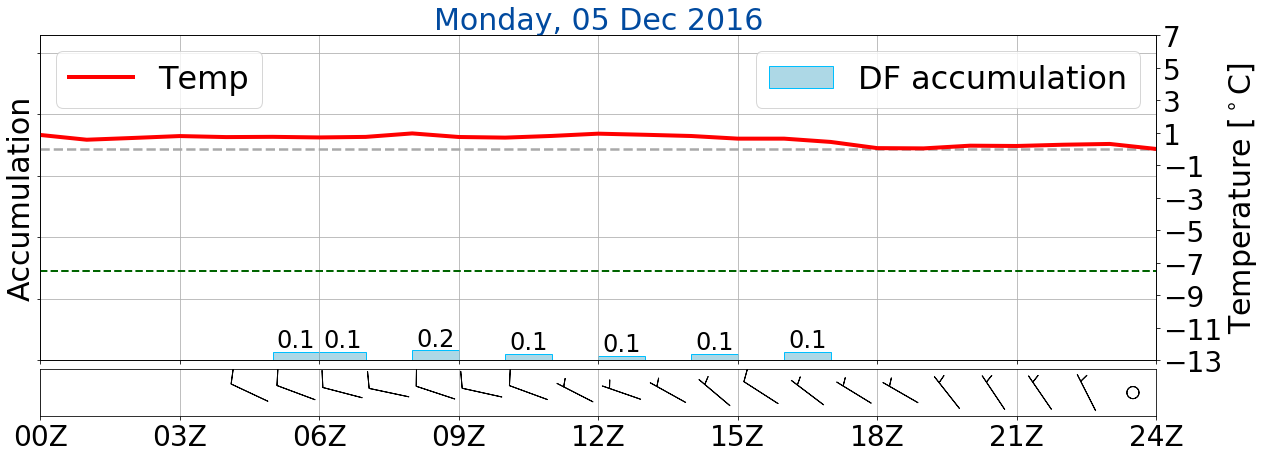

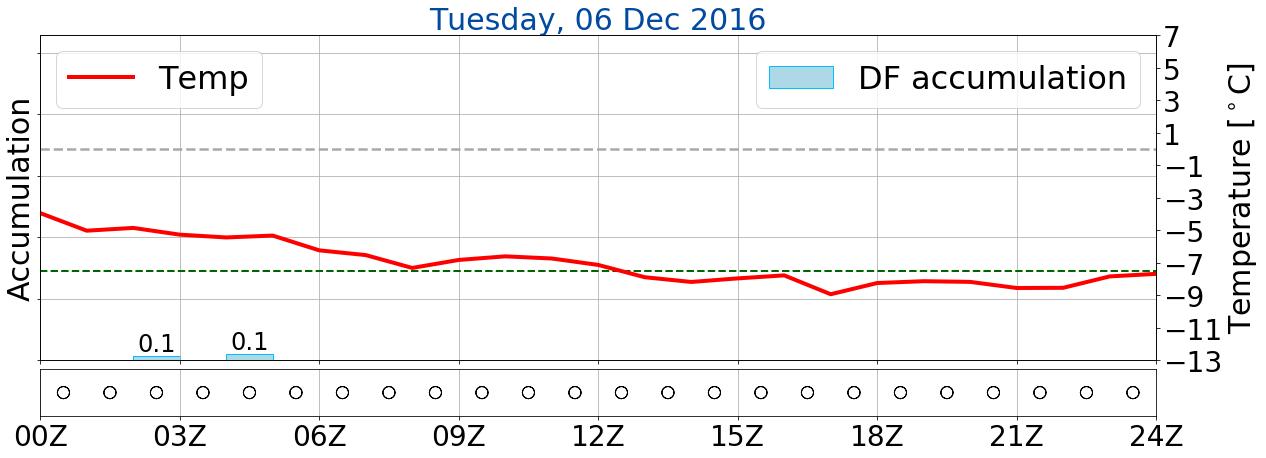

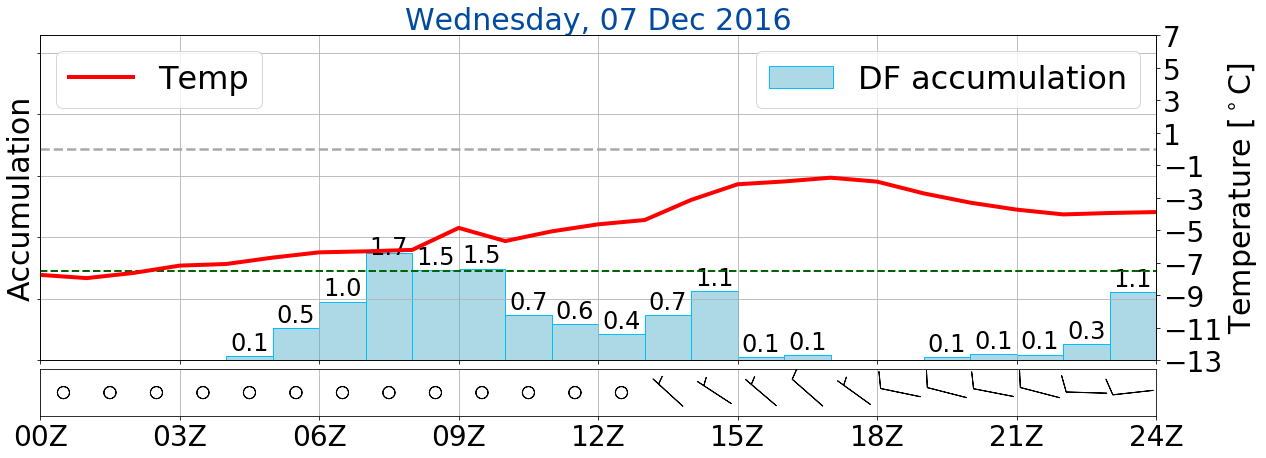

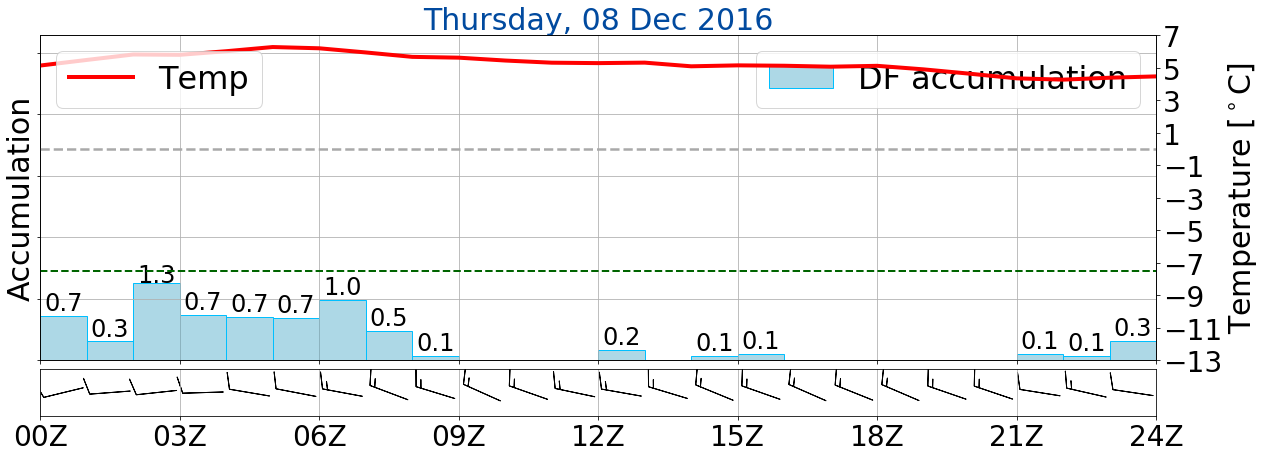

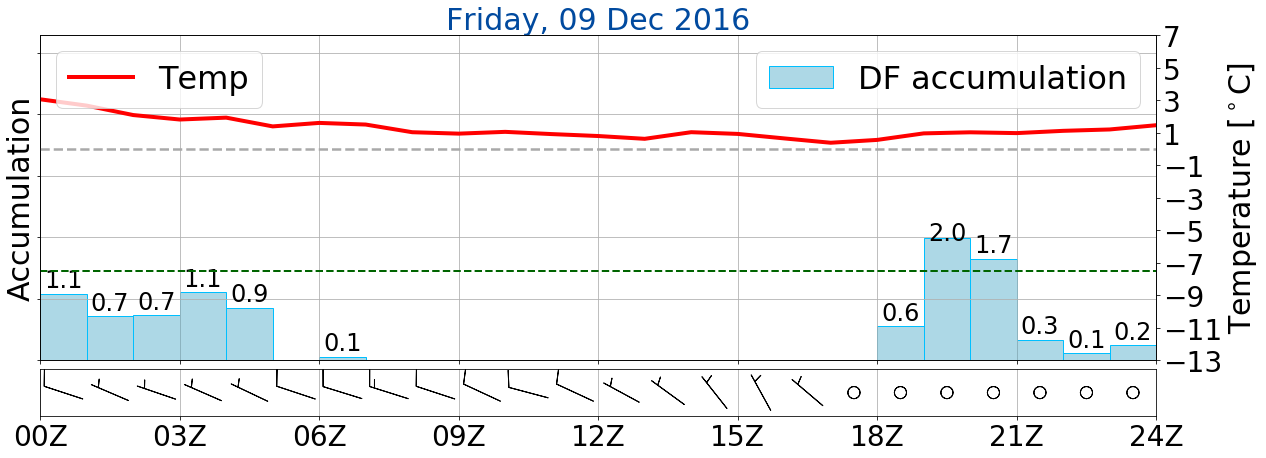

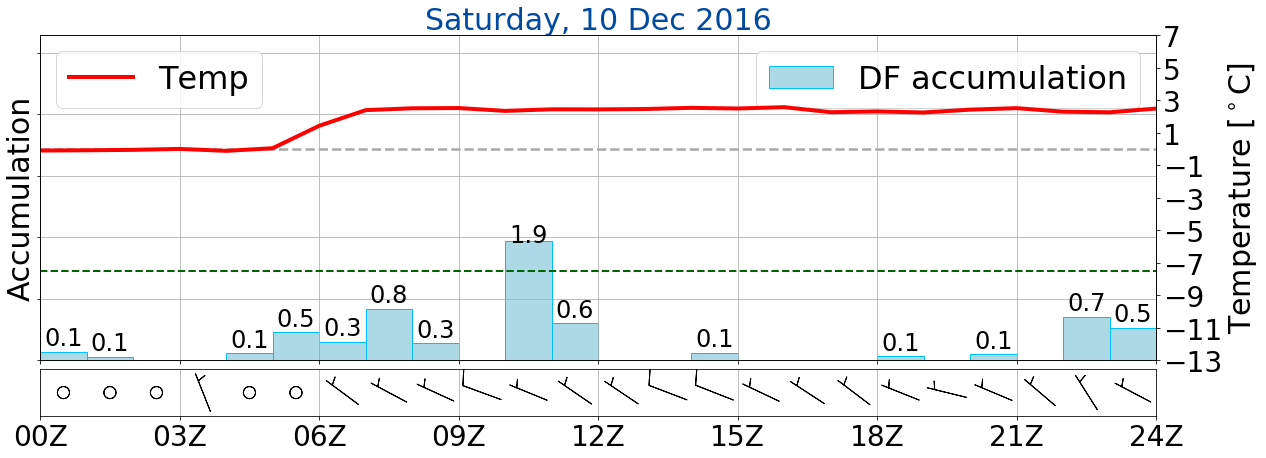

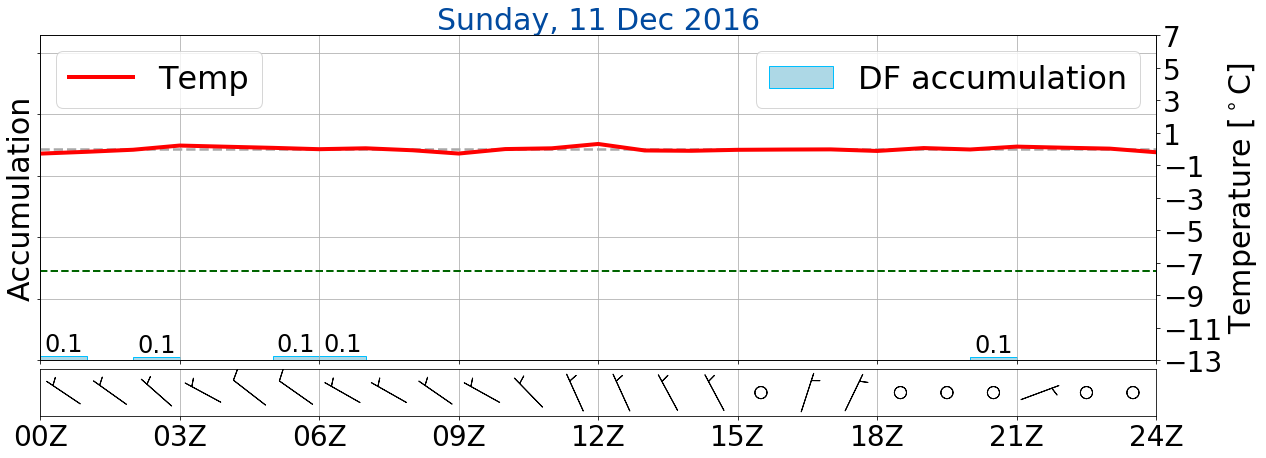

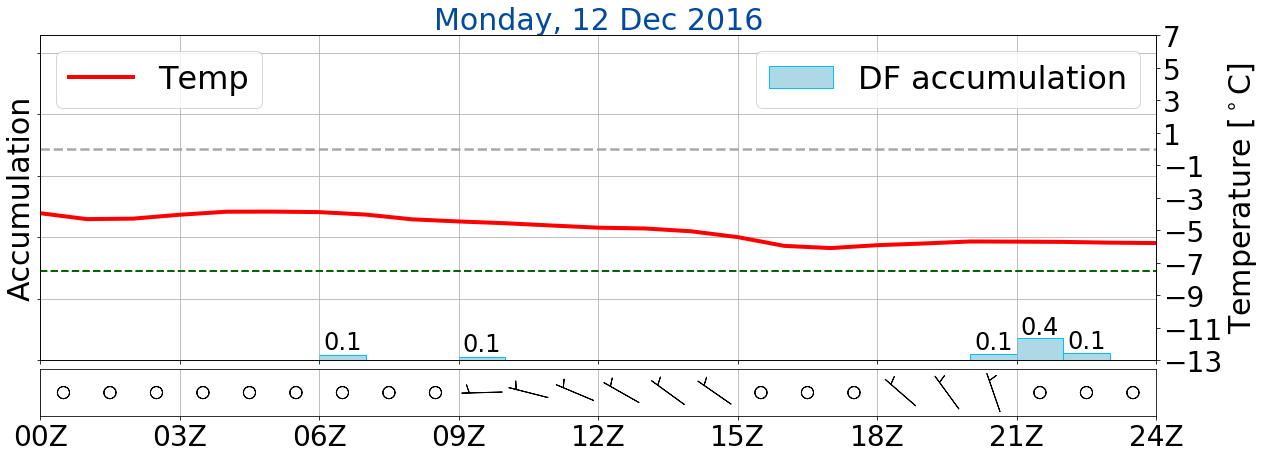

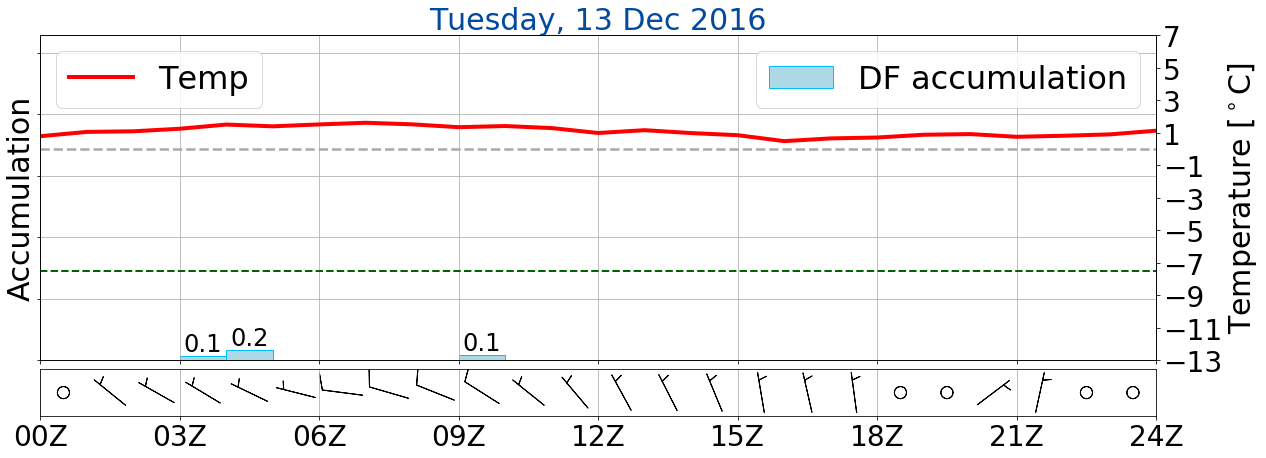

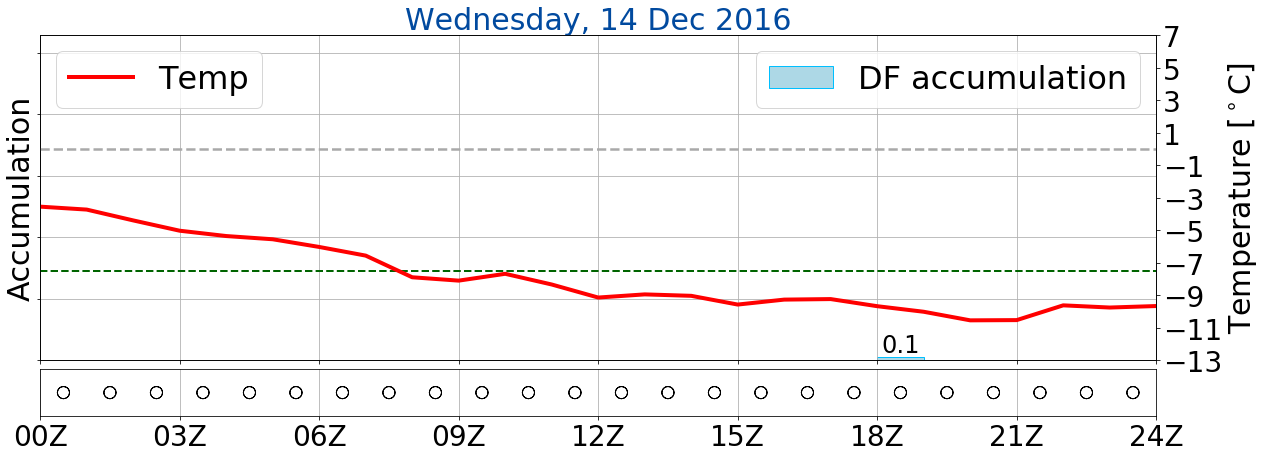

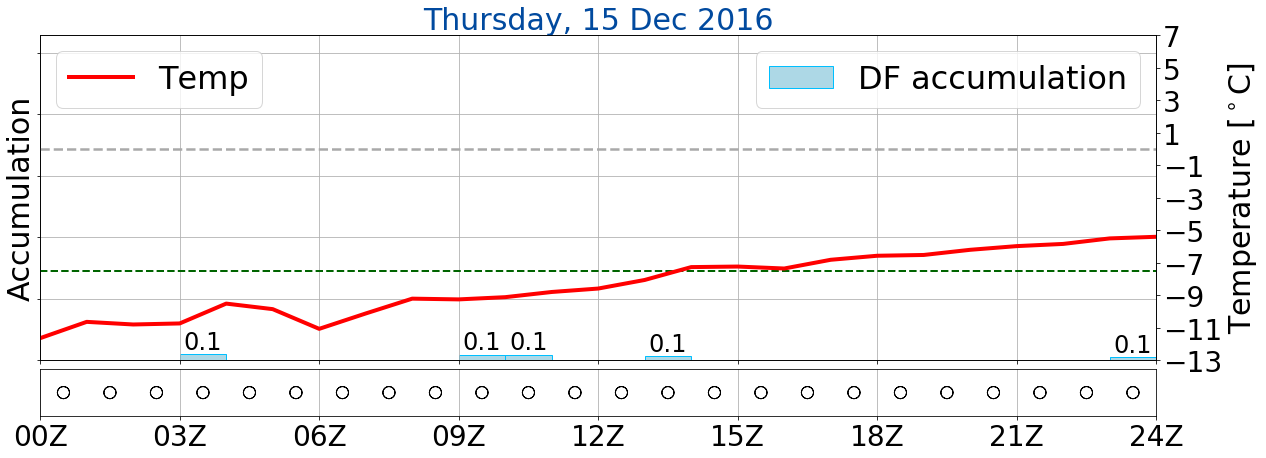

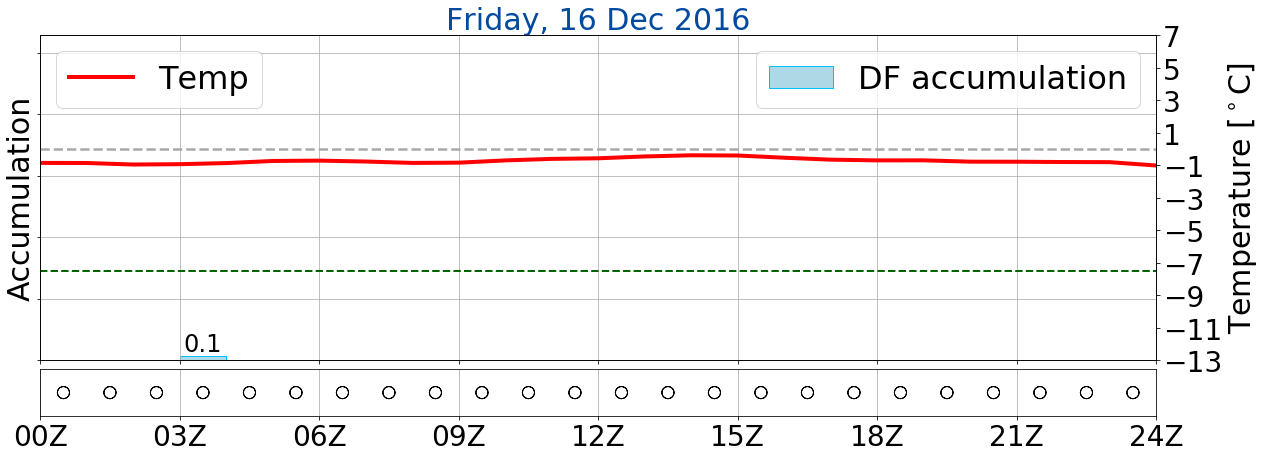

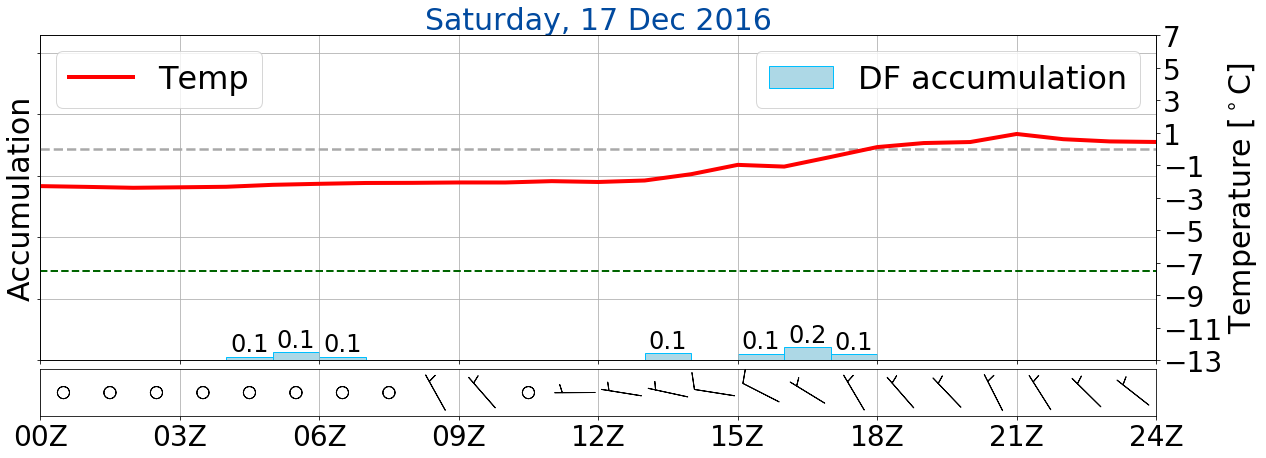

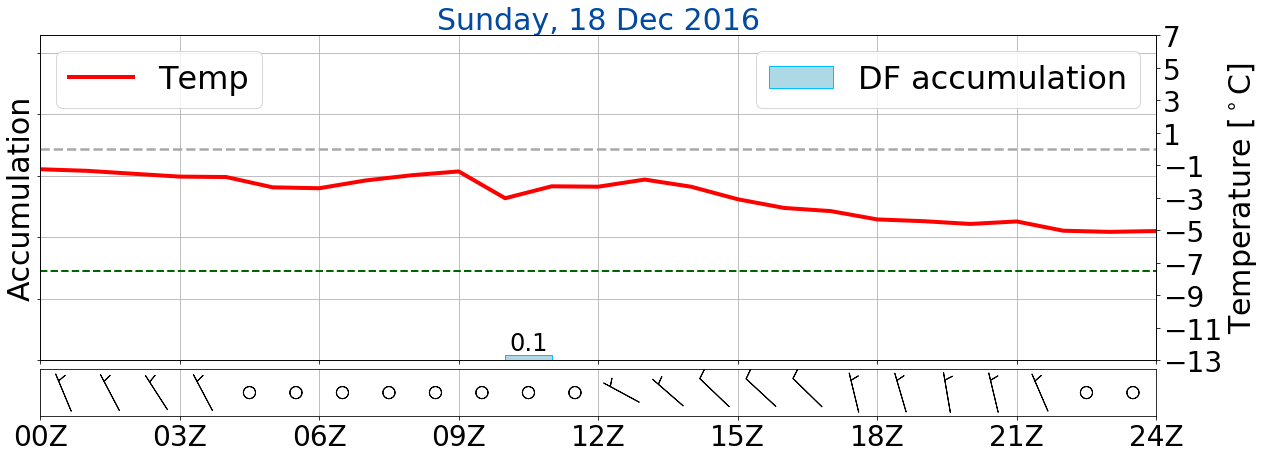

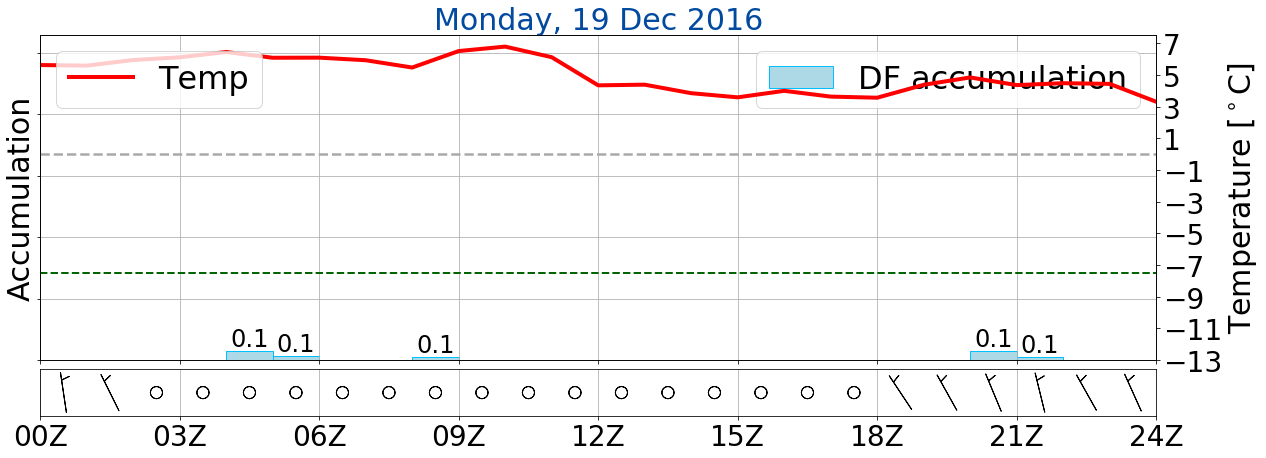

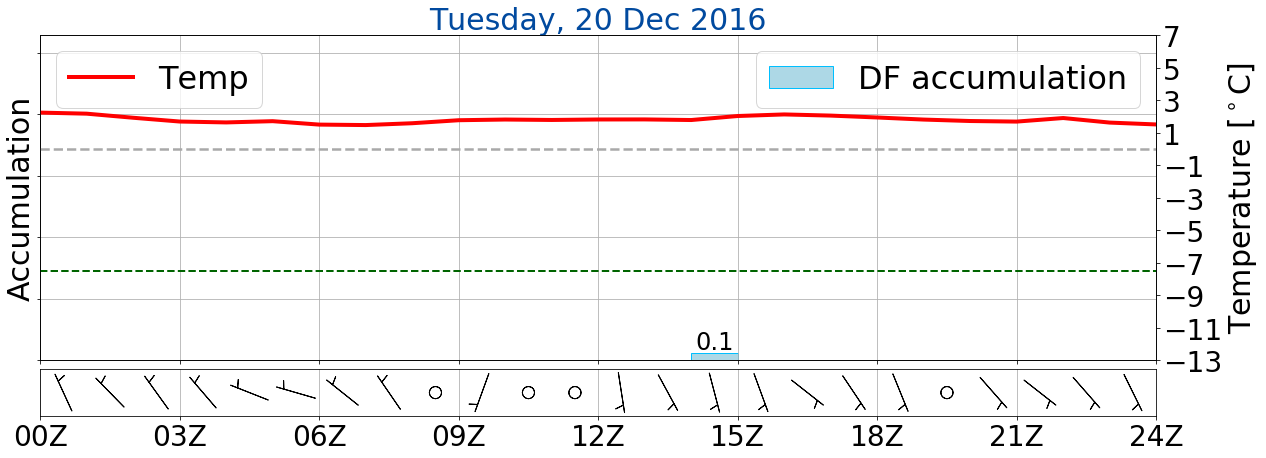

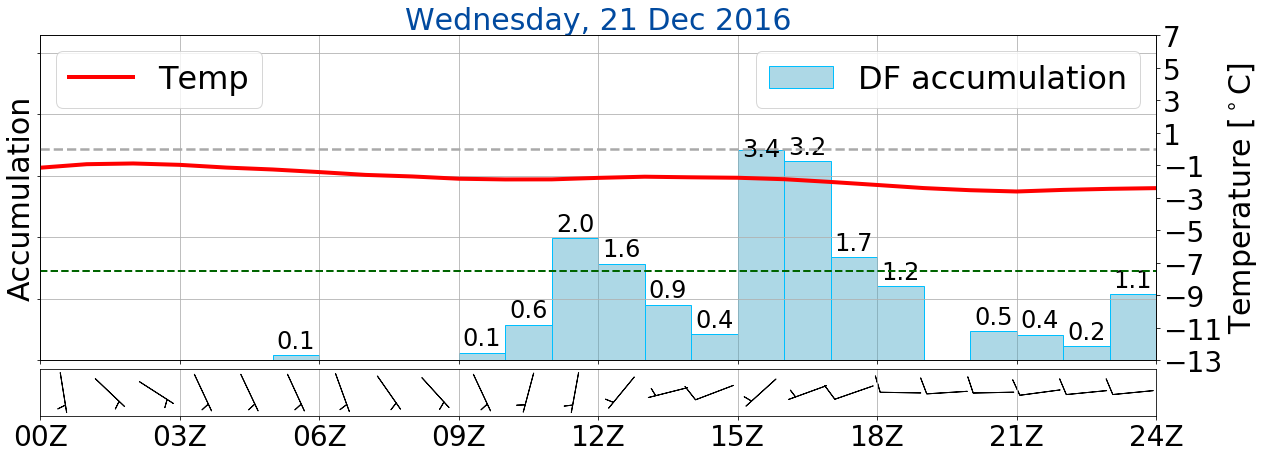

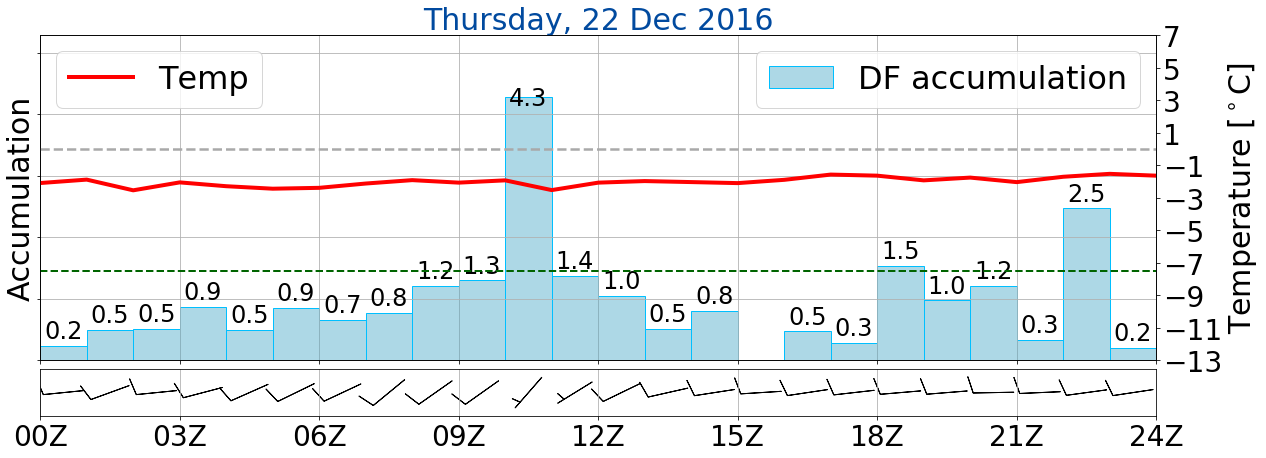

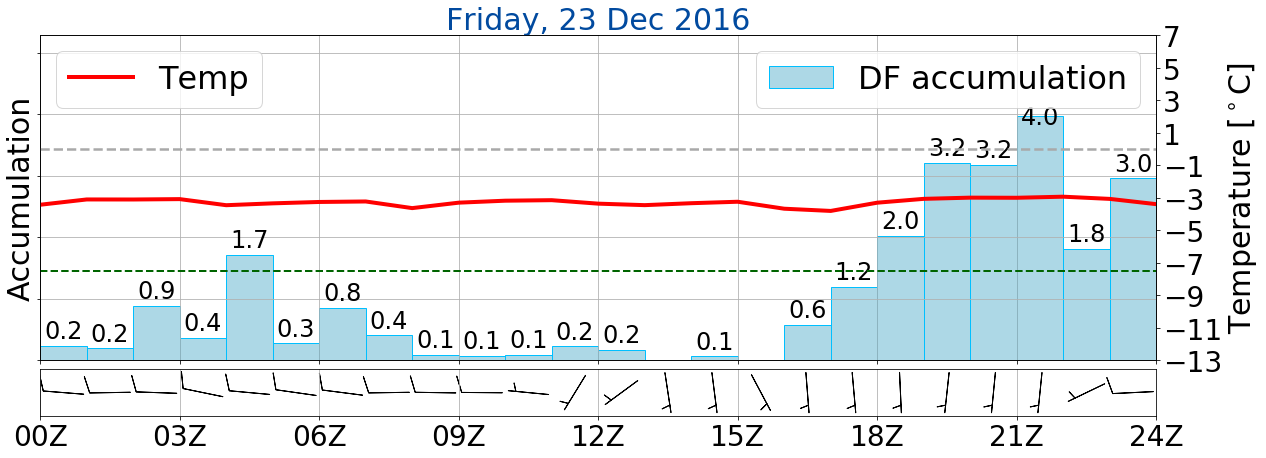

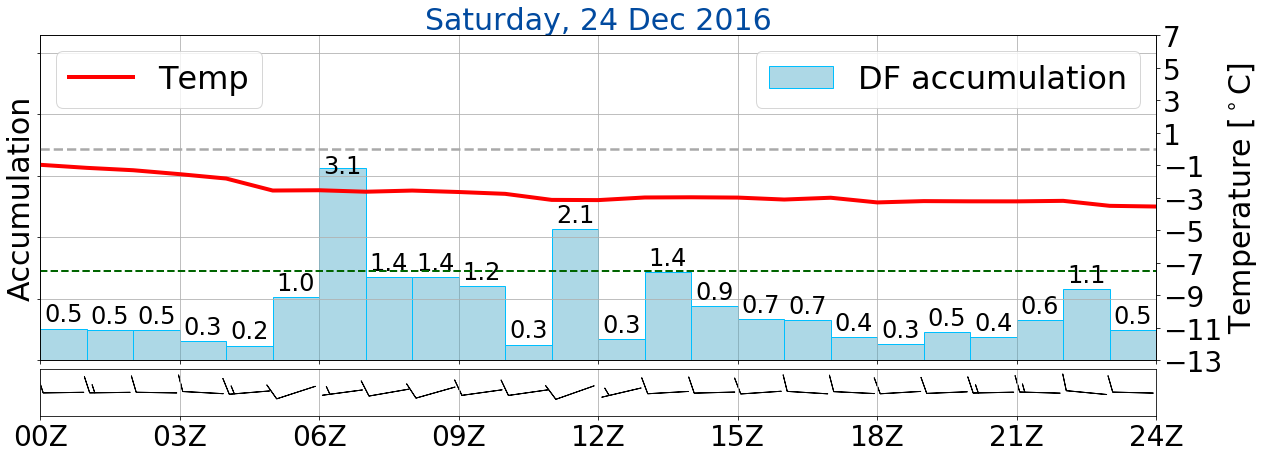

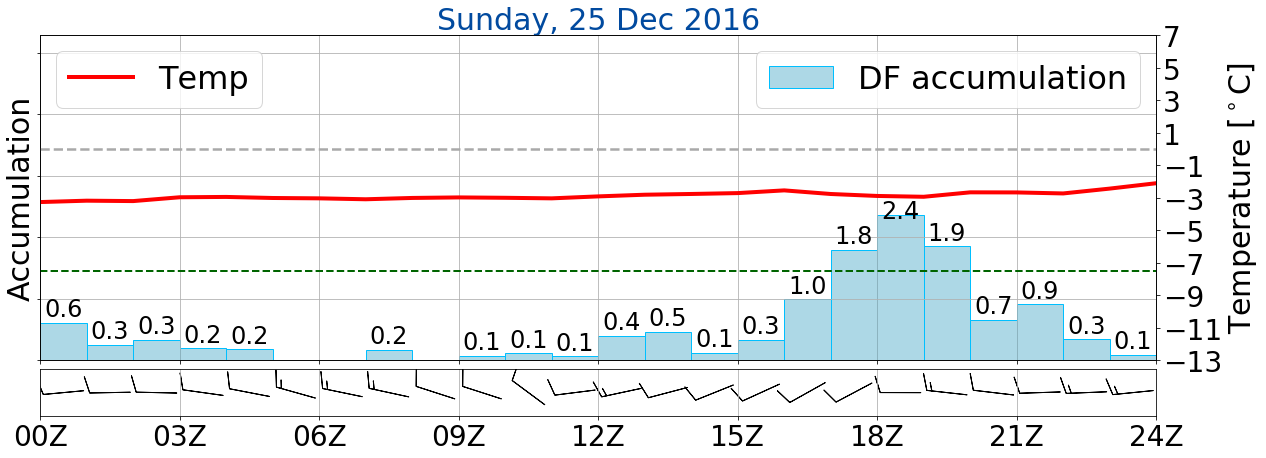

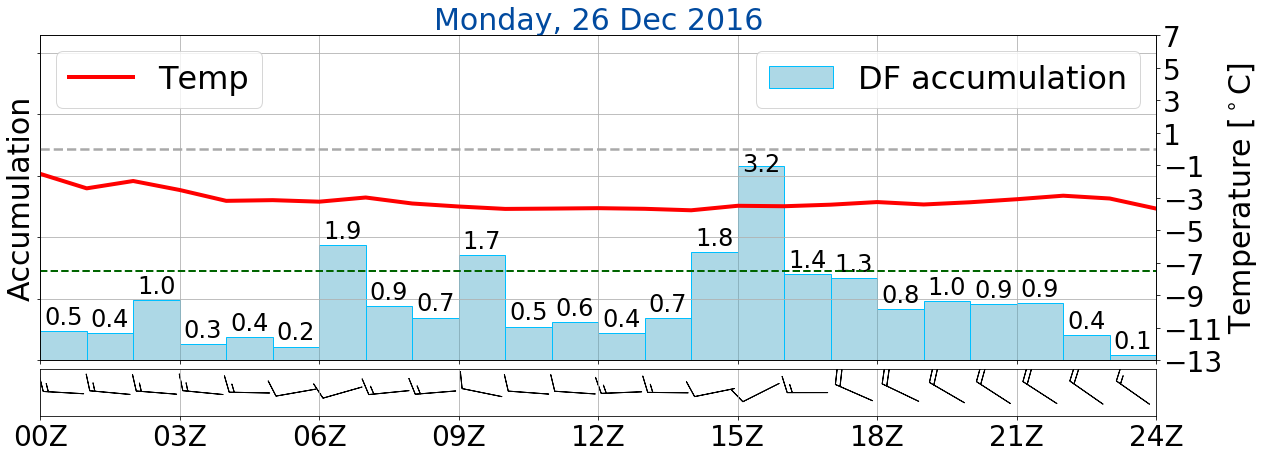

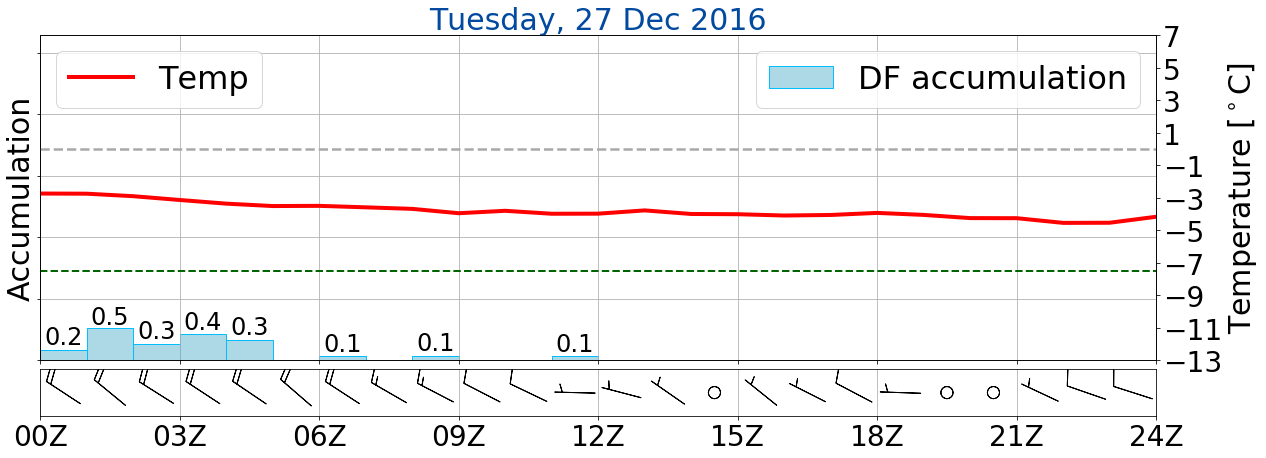

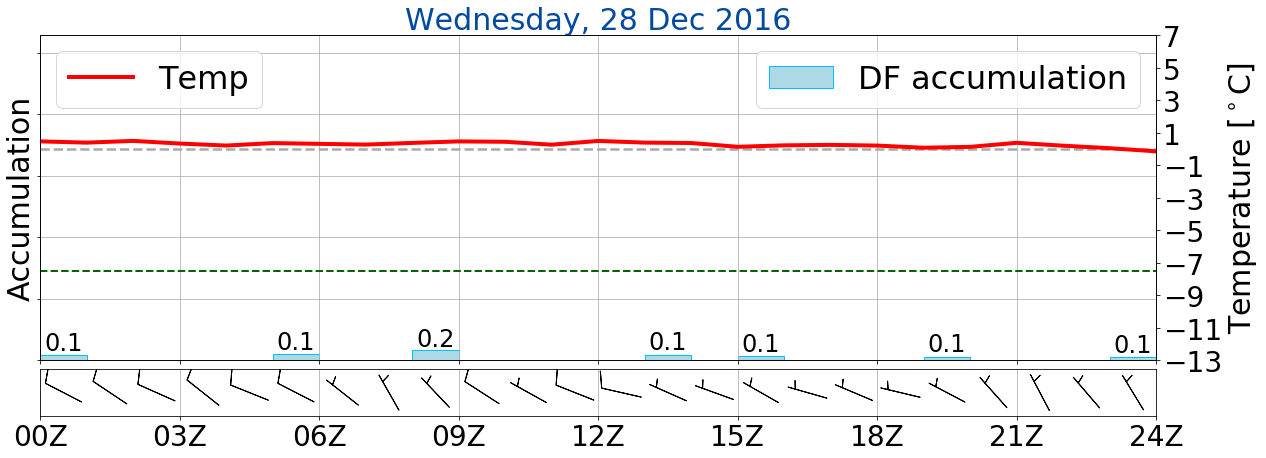

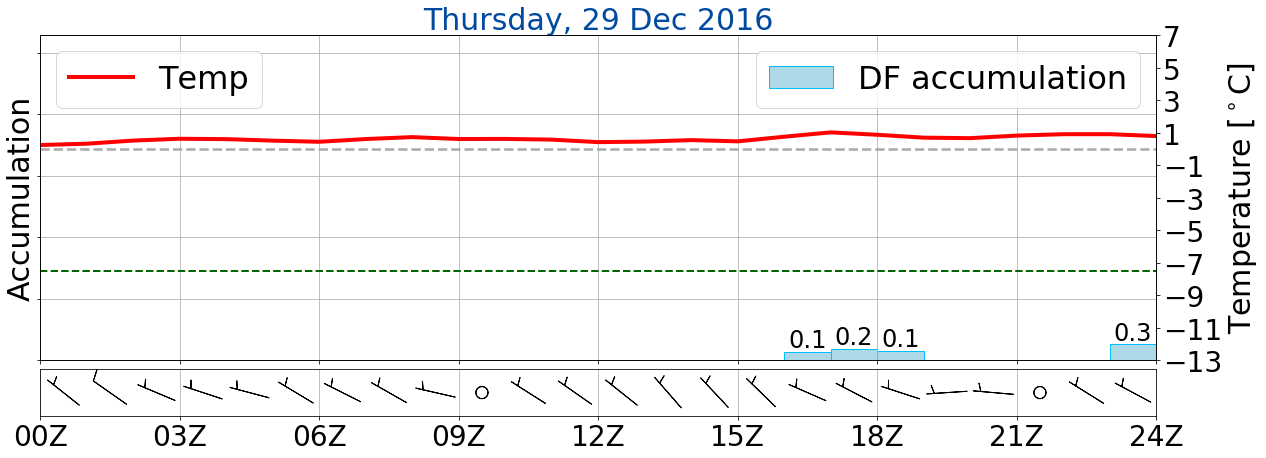

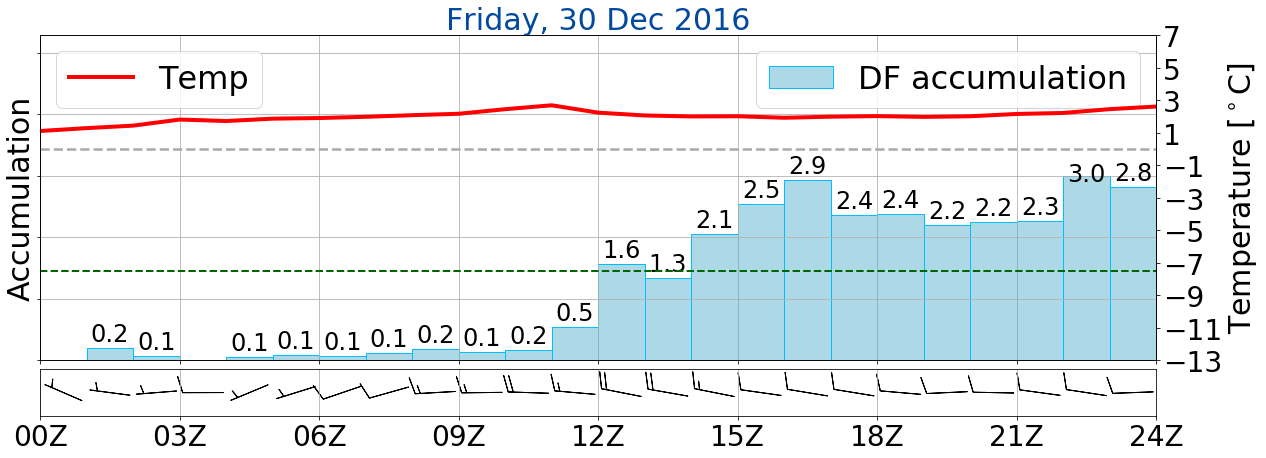

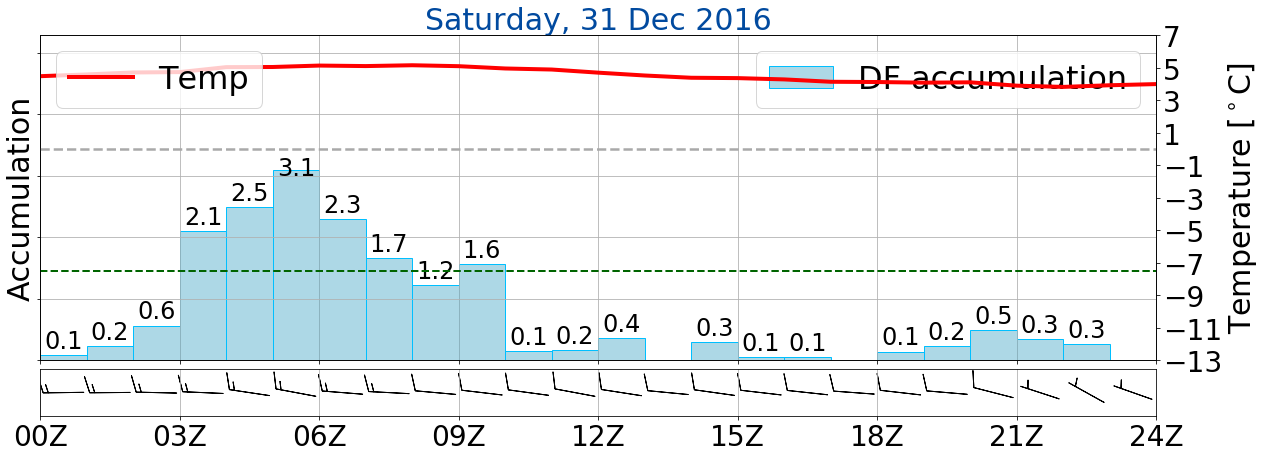

In [15]:
for k in range(4,31):
    calday, calmon = cd.get_dayname(year[:,k],month[:,k],day[:,k])
    
    
    
    # find values wich are not NaN and P => 0.05
    isNaN_P = np.isnan(df_60[:,k])   # Precipitation
    isNaN_T = np.isnan(t_mean[:,k])  # Temperature
    isNaN_U = np.isnan(u_wind_mean[:,k]) # U component Wind
    isNaN_V = np.isnan(v_wind_mean[:,k]) # V component Wind
    
    # Precip
    df_60_mask = df_60[~isNaN_P,k]     # all values without nan
    min_60_mask = min_60[~isNaN_P,:]
    
    df_60_l0 = np.where( df_60_mask > 0.05)   # only values larger than zero
    df_val = df_60_mask[df_60_l0]
    min_60val = min_60_mask[df_60_l0]
    
    # Temperature
    t_mean_mask = t_mean[~isNaN_T,k]
    min_15_mask = min_15[~isNaN_T,:]
    
    # Wind
    X_mask = X[~isNaN_U]
    Y_mask = Y[~isNaN_V]
    uwind_mask = u_wind_mean[~isNaN_U,k]
    vwind_mask = v_wind_mean[~isNaN_V,k]
    
    
    # Days 
    y = year[:,k]
    m = month[:,k]
    d = day[:,k]
    if d < 10:
        d = '0%g' %(d)
    else:
        d = '%g' %(d)
    figname = 'T_P_U_%g%g%s.png' % (y, m, d)
    
    fig = plt.figure(figsize=(20,7))
    fontsize = 30
    if sfig ==1:
        PF.plot_TPU(fig, min_60val, df_val, df_60,
            min_15_mask, t_mean_mask, t_mean,
            X_mask,Y_mask,uwind_mask, vwind_mask,
            calday, d, calmon, y, fs = fontsize)
        SF.save_figure_landscape(figdir, figname, form)
    else:
        PF.plot_TPU(fig, min_60val, df_val, df_60,
            min_15_mask, t_mean_mask, t_mean,
            X_mask,Y_mask,uwind_mask, vwind_mask,
            calday, d, calmon, y, fs = fontsize)
        plt.show()
        
    plt.close()